In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [2]:
import torch.utils.data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

head_classes=[3,4,5]

indices_train = [idx for idx, target in enumerate(trainset.targets) if target in head_classes]
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, indices_train),batch_size=batch_size,shuffle=True,drop_last=True)

indices_test = [idx for idx, target in enumerate(testset.targets) if target in head_classes]
testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, indices_test),batch_size=batch_size,shuffle=True,drop_last=True)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


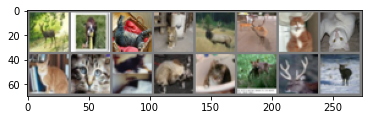

deer  dog   cat   cat   deer  deer  cat   cat   cat   cat   cat   cat   cat   cat   deer  deer 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the multi-head model
class MultiHeadModel(nn.Module):
    def __init__(self):
        super(MultiHeadModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.head1 = nn.Sequential(
            # Add layers for the first head here, e.g., fully connected layers, activation functions, etc.
            nn.Linear(16*5*5, 120),nn.ReLU(),
            nn.Linear(120, 84),nn.ReLU(),
            nn.Linear(84,1),
            nn.Sigmoid()  # Output layer with 4 units and softmax activation for 4-class classification
        )
        # Define the second head for classifying 5 animals
        self.head2 = nn.Sequential(
            # Add layers for the second head here, e.g., fully connected layers, activation functions, etc.
            nn.Linear(16*5*5, 120),nn.ReLU(),
            nn.Linear(120, 84),nn.ReLU(),
            nn.Linear(84, 1),
            nn.Sigmoid()  # Output layer with 6 units and softmax activation for 5-class classification
        )
         # Define the second head for classifying 5 animals
        self.head3 = nn.Sequential(
            # Add layers for the second head here, e.g., fully connected layers, activation functions, etc.
            nn.Linear(16*5*5, 120),nn.ReLU(),
            nn.Linear(120, 84),nn.ReLU(),
            nn.Linear(84, 1),
            nn.Sigmoid()  # Output layer with 6 units and softmax activation for 5-class classification
        )
        

    def forward(self, x):
        # Implement the forward pass of the multi-head model
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        head1_output = self.head1(x)
        head2_output = self.head2(x)
        head3_output = self.head3(x)
        
        return head1_output, head2_output,head3_output

# Instantiate the multi-head model
multi_head_model = MultiHeadModel().to(device)
multi_head_model.train()

MultiHeadModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (head1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (head2): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (head3): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Sigmoid()
  )


In [5]:
# Define the loss functions for each head
loss_function_head1 = nn.BCELoss()
loss_function_head2 = nn.BCELoss()
loss_function_head3 = nn.BCELoss()

# Define the optimizer for training the multi-head model
optimizer = optim.Adam(multi_head_model.parameters(), lr=0.001)
# should finish before training
def find_targets(labels,head):
    # how to generate tensors
    new_labels = labels.clone().detach()
    for idx, t in enumerate(new_labels):
        if t == head:
            new_labels[idx] = 1
        else:
            new_labels[idx] = 0
    return new_labels

# Print the summary of the multi-head model architecture
#print(base_model)
#print(multi_head_model)

In [6]:
# Train the multi-head model
# labels: plane 0, car 1
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print(labels)
        #print(head_classes[0])
        targets1 = find_targets(labels,head_classes[0]).to(device)
        targets1 = targets1.unsqueeze(1).float()

        targets2 = find_targets(labels,head_classes[1]).to(device)
        targets2 = targets2.unsqueeze(1).float()

        targets3 = find_targets(labels,head_classes[2]).to(device)
        targets3 = targets3.unsqueeze(1).float()


        # zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        head1_output, head2_output, head3_output = multi_head_model(inputs)

        # Compute the losses for each head
        loss1 = loss_function_head1(head1_output, targets1)
        loss2 = loss_function_head2(head2_output, targets2)
        loss3 = loss_function_head3(head3_output, targets3)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward(retain_graph=True)
        loss3.backward(retain_graph=True)
        optimizer.step()

        # Print the loss for this epoch
        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss1: {loss1.item()}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss1: {loss1.item()}, Loss2: {loss2.item()}, Loss3: {loss3.item()}")

Epoch [1/20], Loss1: 0.690685510635376, Loss2: 0.42750486731529236, Loss3: 0.5313800573348999
Epoch [2/20], Loss1: 0.5289499759674072, Loss2: 0.3551619350910187, Loss3: 0.3361262381076813
Epoch [3/20], Loss1: 0.5432628393173218, Loss2: 0.346779465675354, Loss3: 0.4859811067581177
Epoch [4/20], Loss1: 0.41282638907432556, Loss2: 0.2926447093486786, Loss3: 0.6741012334823608
Epoch [5/20], Loss1: 0.24013984203338623, Loss2: 0.20138706266880035, Loss3: 0.34082308411598206
Epoch [6/20], Loss1: 0.6402894854545593, Loss2: 0.1308378428220749, Loss3: 0.6472319960594177
Epoch [7/20], Loss1: 0.3483228087425232, Loss2: 0.3025112748146057, Loss3: 0.35482800006866455
Epoch [8/20], Loss1: 0.35303956270217896, Loss2: 0.04100475832819939, Loss3: 0.21545769274234772
Epoch [9/20], Loss1: 0.26155975461006165, Loss2: 0.11866050958633423, Loss3: 0.26171305775642395
Epoch [10/20], Loss1: 0.25021934509277344, Loss2: 0.10854382067918777, Loss3: 0.22846829891204834
Epoch [11/20], Loss1: 0.5141028761863708, Loss

In [7]:
PATH = './mcifar_net.pth'
torch.save(multi_head_model.state_dict(), PATH)

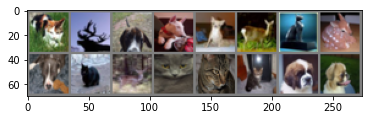

GroundTruth:  cat   deer  dog   dog   dog   deer  cat   deer  dog   cat   deer  cat   cat   cat   dog   dog  
Accuracy of the network on the test images: 93 %


In [20]:
ataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))
correct = 0
total = 0
multi_head_model.eval().to(device)
labels.to(device)
head1_output, head2_output, head3_output = multi_head_model(images.to(device))
for h1,h2,h3,lb in zip (head1_output,head2_output,head3_output,labels):
    hlist = [h1,h2,h3]
    predicted = hlist.index(max(hlist))
    if head_classes[predicted] == lb:
        correct+=1
    total+=1
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [21]:
# Evaluate the multi-head model
correct = 0
total = 0
#multi_head_model.eval().to(device)
with torch.no_grad():
    for data in testloader:
        images,labels = data
        images = images.to(device)
        labels = labels.to(device)

        head1_output, head2_output, head3_output = multi_head_model(images)
        for h1,h2,h3,lb in zip (head1_output,head2_output,head3_output,labels):
            hlist = [h1,h2,h3]
            predicted = hlist.index(max(hlist))
            if head_classes[predicted] == lb:
                correct+=1
            total+=1
    print(f'Accuracy of the network on the test images: {100 * correct // total} %')                
        
    # Compute and print the accuracy for each head
    #accuracy1 = (torch.argmax(head1_output, dim=1) == targets1).sum().item() / len(targets1)
    #accuracy2 = (torch.argmax(head2_output, dim=1) == targets2).sum().item() / len(targets2)
    #print(f"Head1 Accuracy: {accuracy1}, Head2 Accuracy: {accuracy2}")

Accuracy of the network on the test images: 66 %


In [10]:
# stop here